# Exploring Dandiset 001174: Calcium Imaging in SMA and M1 of Macaques

*A practical guide for re-analysis and exploration of neural population data from rhesus macaques during rest and arm reaching*

---

**Important:**  
This notebook was generated with assistance from AI. While the code and explanations are based on publicly described content of the dataset and inspection of the files, users should exercise caution and validate results in their own workflow.

---

## Overview of Dandiset 001174

[**Dandiset 001174: Calcium imaging in SMA and M1 of macaques**](https://dandiarchive.org/dandiset/001174/0.250331.2218) contains population-scale calcium imaging data from the supplementary motor area (SMA) and primary motor cortex (M1) of rhesus monkeys. The dataset includes:

- In vivo one-photon calcium imaging using GCaMP6f and miniaturized endoscopes  
- Data from both spontaneous (rest) and arm reaching task conditions  
- Segmentation of neuronal regions of interest (ROIs), processed traces, and event amplitudes  
- Detailed NWB-format files with imaging, processing, and metadata

## What this notebook covers
- Introduction to the structure of this Dandiset, including session and data modalities
- Loading and browsing NWB file assets using the DANDI API (streamed, not downloaded)
- Inspecting major data types: raw imaging frames, ROI segmentation, processed fluorescence/event signals
- Visualizing example neural traces and cell footprints
- Guidance for accessing and extending analyses to the rest of the dataset

## Required Packages

- `dandi` (DANDI API client)
- `remfile` (remote file streaming)
- `pynwb` (for working with NWB format)
- `h5py` (streaming HDF5/NWB file reading)
- `matplotlib` (visualizations)
- `numpy` (numerical operations)

All packages are assumed to be pre-installed on your system.

---

## 1. Loading Dandiset Assets with the DANDI API

Here we demonstrate how to use the DANDI Python client to list available NWB files from Dandiset 001174 (version 0.250331.2218), so you can quickly browse sessions of interest.

In [1]:
from dandi.dandiapi import DandiAPIClient
from itertools import islice

dandiset_id = "001174"
dandiset_version = "0.250331.2218"

with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandiset_id, dandiset_version)
    # List available NWB asset paths (limit to 10 for display here)
    asset_paths = [asset.path for asset in islice(dandiset.get_assets_by_glob("*.nwb"), 10)]

print("Example NWB file assets in the dandiset:")
for path in asset_paths:
    print(" -", path)

Example NWB file assets in the dandiset:
 - sub-V/sub-V_ses-20230309T110929_ophys.nwb
 - sub-Q/sub-Q_ophys.nwb
 - sub-Q/sub-Q_ses-20220922T131747_ophys.nwb
 - sub-Q/sub-Q_ses-20221003T131952_ophys.nwb
 - sub-Q/sub-Q_ses-20221028T121142_ophys.nwb
 - sub-Q/sub-Q_ses-20221201T132256_ophys.nwb
 - sub-Q/sub-Q_ses-20221202T122907_ophys.nwb
 - sub-Q/sub-Q_ses-20221206T121002_ophys.nwb
 - sub-Q/sub-Q_ses-20220915T133954_ophys.nwb
 - sub-Q/sub-Q_ses-20221201T134628_ophys.nwb


## 2. Overview: NWB File Structure in This Dataset

Each NWB file includes several main data modalities:

- **Raw Imaging Data** (`acquisition/OnePhotonSeries`): 3D movie (frames x height x width, uint16)
- **ROI Segmentation** (`processing/ophys/ImageSegmentation/PlaneSegmentation`): Masks for each cell/ROI
- **Processed Signals**
  - Fluorescence traces (`processing/ophys/Fluorescence/RoiResponseSeries`): ΔF/F or similar for each ROI
  - Event amplitude traces (`processing/ophys/EventAmplitude`): For discrete calcium events
- **Metadata** (subject info, device, imaging parameters)

Some files represent spontaneous conditions (rest), others represent the "arm reaching" task. Let's explore example files of each type.

## 3. Exploring a Spontaneous (Rest) Session NWB File

We'll use `sub-Q/sub-Q_ophys.nwb` as an example of a spontaneous condition session.

In [2]:
import remfile
import h5py
import pynwb

# Select a spontaneous-condition file
spontaneous_file = "sub-Q/sub-Q_ophys.nwb"

# Re-obtain asset for remote streaming
with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandiset_id, dandiset_version)
    asset = next(dandiset.get_assets_by_glob(spontaneous_file))

remote_file = remfile.File(asset.download_url)
h5_file = h5py.File(remote_file, "r")
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

# Inspect basic structure
print(f"Session description: {nwb.session_description}")
print(f"Imaging start time: {nwb.session_start_time}")
print(f"Subject ID: {nwb.subject.subject_id}; Species: {nwb.subject.species}; Sex: {nwb.subject.sex}")
print(f"Device: {list(nwb.devices.keys())}")
print(f"Acquisition keys: {list(nwb.acquisition.keys())}")
print(f"Ophys processing keys: {list(nwb.processing['ophys'].data_interfaces.keys())}")

Session description: Calcium imaging in SMA during the spontaneous condition
Imaging start time: 2022-09-15 13:16:33.129000+00:00
Subject ID: Q; Species: Macaca mulatta; Sex: F
Device: ['Miniscope']
Acquisition keys: ['OnePhotonSeries']
Ophys processing keys: ['EventAmplitude', 'Fluorescence', 'ImageSegmentation']


### 3.1. Raw Imaging Data: Check Shape and Type

In [3]:
ops = nwb.acquisition['OnePhotonSeries']
raw_data_shape = ops.data.shape
raw_data_dtype = ops.data.dtype

print("Raw imaging data shape:", raw_data_shape)
print("Raw imaging data dtype:", raw_data_dtype)

Raw imaging data shape: (6041, 320, 200)
Raw imaging data dtype: uint16


### 3.2. ROI Segmentation: How Many Neurons?

In [4]:
segmentation = nwb.processing['ophys'].data_interfaces['ImageSegmentation']
plane_seg = segmentation.plane_segmentations['PlaneSegmentation']
num_rois = plane_seg.image_mask.shape[0]

print("Number of segmented ROIs/cells:", num_rois)

Number of segmented ROIs/cells: 40


### 3.3. Fluorescence Trace Example: First ROI, First 5 Timepoints

In [5]:
fl = nwb.processing['ophys'].data_interfaces['Fluorescence']
roi_series = fl.roi_response_series['RoiResponseSeries']
fluor_first5_firstROI = roi_series.data[:5, 0]

print("First 5 timepoints of fluorescence for ROI 0:", fluor_first5_firstROI)

First 5 timepoints of fluorescence for ROI 0: [0. 0. 0. 0. 0.]


### 3.4. Plot: Full Fluorescence Trace for ROI 0

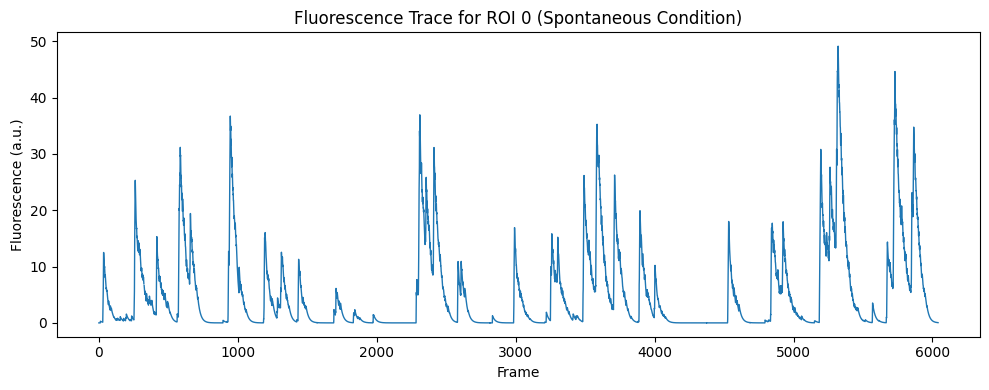

In [6]:
import matplotlib.pyplot as plt

fluor_trace = roi_series.data[:, 0]  # All timepoints for ROI 0

plt.figure(figsize=(10, 4))
plt.plot(fluor_trace, lw=1.0)
plt.title('Fluorescence Trace for ROI 0 (Spontaneous Condition)')
plt.xlabel('Frame')
plt.ylabel('Fluorescence (a.u.)')
plt.tight_layout()
plt.show()

### 3.5. Plot: Spatial Footprint of ROI 0

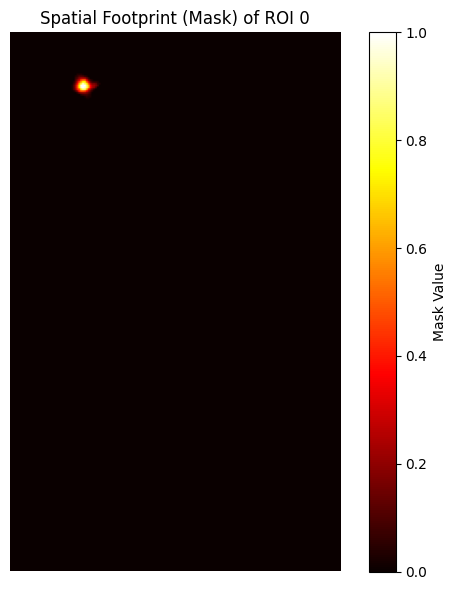

In [7]:
mask0 = plane_seg.image_mask[0]

plt.figure(figsize=(6, 6))
plt.imshow(mask0, cmap='hot')
plt.title('Spatial Footprint (Mask) of ROI 0')
plt.axis('off')
plt.colorbar(label='Mask Value')
plt.tight_layout()
plt.show()

### 3.6. Calcium Event Amplitudes: Visualization

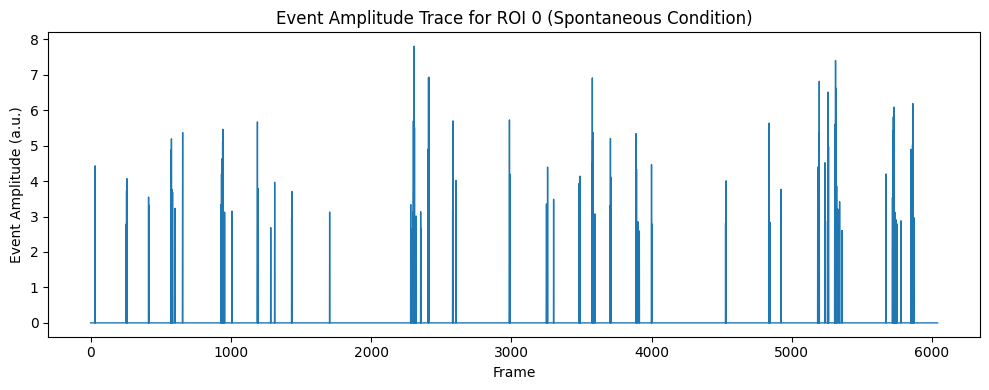

In [8]:
ea = nwb.processing['ophys'].data_interfaces['EventAmplitude']
event_ampl_trace_roi0 = ea.data[:, 0]  # All event amplitudes for ROI 0

plt.figure(figsize=(10, 4))
plt.plot(event_ampl_trace_roi0, lw=1.0)
plt.title('Event Amplitude Trace for ROI 0 (Spontaneous Condition)')
plt.xlabel('Frame')
plt.ylabel('Event Amplitude (a.u.)')
plt.tight_layout()
plt.show()

### 3.7. Histogram of Nonzero Event Amplitudes (All ROIs, All Timepoints)

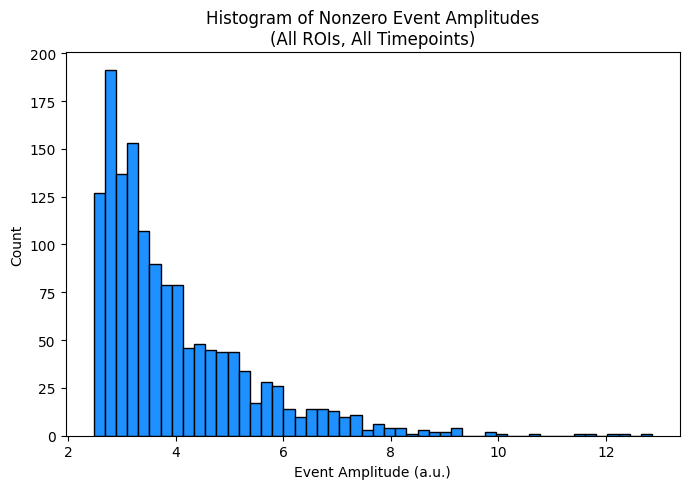

In [9]:
import numpy as np

event_ampl_all = ea.data[:, :]
nonzero_amplitudes = event_ampl_all[event_ampl_all > 0]

plt.figure(figsize=(7,5))
plt.hist(nonzero_amplitudes, bins=50, color='dodgerblue', edgecolor='k')
plt.title('Histogram of Nonzero Event Amplitudes\n(All ROIs, All Timepoints)')
plt.xlabel('Event Amplitude (a.u.)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 4. Exploring an Arm Reaching Task Session NWB File

Now let's repeat similar exploration for a session recorded during the arm reaching task:

**File:** `sub-V/sub-V_ses-20230309T110929_ophys.nwb`  
*(This session has a larger field of view and slightly different cell count and traces.)*

In [10]:
reaching_file = "sub-V/sub-V_ses-20230309T110929_ophys.nwb"

with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandiset_id, dandiset_version)
    asset = next(dandiset.get_assets_by_glob(reaching_file))

remote_file2 = remfile.File(asset.download_url)
h5_file2 = h5py.File(remote_file2, "r")
io2 = pynwb.NWBHDF5IO(file=h5_file2, load_namespaces=True)
nwb2 = io2.read()

print(f"Session description: {nwb2.session_description}")
print(f"Imaging start time: {nwb2.session_start_time}")
print(f"Subject ID: {nwb2.subject.subject_id}; Device: {list(nwb2.devices.keys())}")

Session description: Calcium imaging in M1 during the arm reaching condition
Imaging start time: 2023-03-09 11:09:29.585000+00:00
Subject ID: V; Device: ['Miniscope']


### 4.1. Raw Imaging and ROI Counts

In [11]:
ops2 = nwb2.acquisition['OnePhotonSeries']
print("Raw imaging data shape:", ops2.data.shape)
print("Raw imaging data dtype:", ops2.data.dtype)

segmentation2 = nwb2.processing['ophys'].data_interfaces['ImageSegmentation']
plane_seg2 = segmentation2.plane_segmentations['PlaneSegmentation']
print("Number of segmented ROIs/cells:", plane_seg2.image_mask.shape[0])

Raw imaging data shape: (5185, 1280, 800)
Raw imaging data dtype: uint16
Number of segmented ROIs/cells: 11


### 4.2. Plot: Fluorescence Trace & Mask for ROI 0

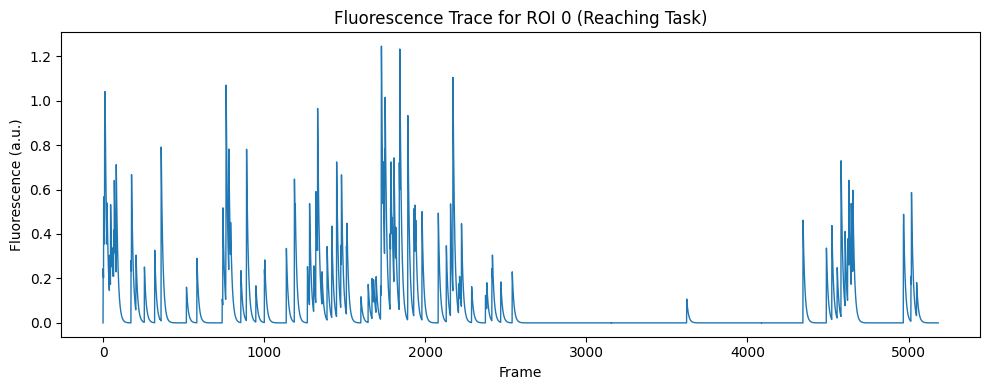

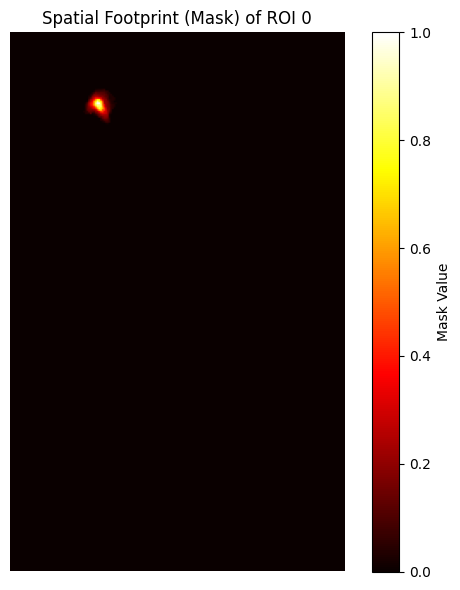

In [12]:
roi_series2 = nwb2.processing['ophys'].data_interfaces['Fluorescence'].roi_response_series['RoiResponseSeries']
fluor_trace2 = roi_series2.data[:, 0]

plt.figure(figsize=(10,4))
plt.plot(fluor_trace2, lw=1.0)
plt.title('Fluorescence Trace for ROI 0 (Reaching Task)')
plt.xlabel('Frame')
plt.ylabel('Fluorescence (a.u.)')
plt.tight_layout()
plt.show()

mask0_2 = plane_seg2.image_mask[0]
plt.figure(figsize=(6,6))
plt.imshow(mask0_2, cmap='hot')
plt.title('Spatial Footprint (Mask) of ROI 0')
plt.axis('off')
plt.colorbar(label='Mask Value')
plt.tight_layout()
plt.show()

## 5. Summary and Next Steps

- This notebook demonstrated how to stream and browse the core calcium imaging and processed ROI data in Dandiset 001174.
- Each NWB file contains: high-resolution imaging frames, cell segmentation masks, and time series of fluorescence signals and event amplitudes.
- Sessions may differ by condition (spontaneous vs. arm reaching task), size (# ROIs), and imaging field.

**To extend your exploration:**
- Iterate over more files or ROIs to extract population metrics, spatial organization, or event statistics.
- Cross-reference session/subject metadata for experimental context.
- Export traces or masks for integration with your preferred analysis pipelines.

---

_For more details, see the [Dandiset page](https://dandiarchive.org/dandiset/001174/0.250331.2218) or the [associated preprint](https://www.biorxiv.org/content/10.1101/2024.06.20.599918v3) on bioRxiv._  

---  
_Notebook generated with AI assistance; validate all findings for your research workflow!_